## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Distortion Correction Parameter

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [3]:
# plot the original images and corrected images

for imgName in images:
    img = cv2.imread(imgName)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undistorted = cv2.undistort(gray, mtx, dist, None, mtx)
    tmp = np.vstack((gray, undistorted))
    cv2.imshow('img', tmp)
    cv2.waitKey(500)
cv2.destroyAllWindows()

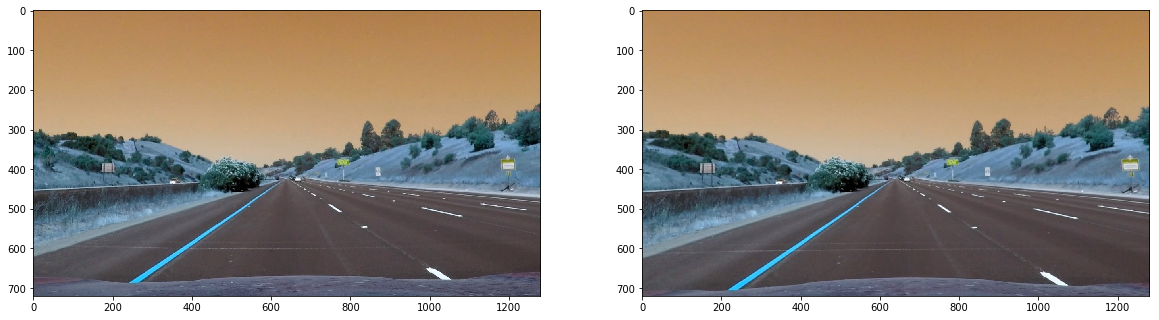

In [4]:
%matplotlib inline 
# test on stright line images 
test_images = glob.glob('./test_images/*.jpg')
img = cv2.imread(test_images[0])
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img)
ax2.imshow(undist)

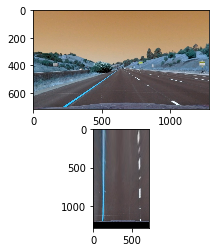

In [64]:
#perspective transf
nx = 1280
ny = 720

img = cv2.imread(test_images[0])
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(211)
plt.imshow(undistorted, cmap='gray')

src = np.float32([[585,450],[695,450],[1160,ny],[120,ny]])
dst = np.float32([[80,80],[ny-80,80],[ny-80, nx-80],[80,nx-80]])
# dst = np.float32([[0,0],[ny,0],[ny, nx],[0,nx]])

M    = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undistorted, M, (img.shape[0], img.shape[1]), flags=cv2.INTER_LINEAR)
plt.subplot(212)
plt.imshow(warped, cmap='gray')

## gradient && threshold

In [58]:
## different kinds of gradient and threshold
def xDirGradThreshold(img, sobel_kernel=3, thresh = (0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    binary_output = np.zeros_like(sobelx)
    binary_output[(sobelx >= thresh[0])& (sobelx <= thresh[1])] = 1
    return binary_output
    
def yDirGradThreshold(img, sobel_kernel=3, thresh = (0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    binary_output = np.zeros_like(sobely)
    binary_output[(sobely >= thresh[0])&(sobely <= thresh[1])] = 1
    return binary_output

def magGradThreshold(img, sobel_kernel=3, thresh = (0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobelMag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobelMag = np.uint8(255*sobelMag/np.max(sobelMag))
    
    binary_output = np.zeros_like(scaled_sobelMag)
    binary_output[(scaled_sobelMag > thresh[0])&(scaled_sobelMag < thresh[1])] = 1
    return binary_output

def dirGradThreshold(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dirGrd = np.arctan2(abs_sobely, abs_sobelx)

    binary_output = np.zeros_like(dirGrd)
    binary_output[(dirGrd >= thresh[0])&(dirGrd <= thresh[1])] = 1
    return binary_output

def hlsGradThreshold(img, sobel_kernel=3, thresh=(0,10)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

def absoluteGradThreshold(img, orientation='x', sobel_kernel=3, thresh=(0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if orientation == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    elif orientation == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    else:
        return 'wrong direction'

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel) 
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_output
    

In [65]:
#combination of gradient thresh
def combinationGD(img):
    
    binary_mag = magGradThreshold(img, 3, (40,255))
    binary_hls = hlsGradThreshold(img, 3, (100,255))
    binary_dir = dirGradThreshold(img, 3, (0.6,1.5))
    binary_xabs = absoluteGradThreshold(img, 'x', 3, (10,255))
    binary_comb = np.zeros_like(binary_mag)
    binary_comb[((binary_mag==1) & (binary_dir==1))|((binary_hls==1)&(binary_xabs==1))] = 1
    
    return binary_comb

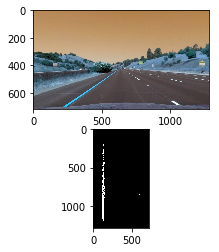

In [66]:
#perspective transf

img = cv2.imread(test_images[0])
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
binaryComb = combinationGD(undistorted)
plt.subplot(211)
plt.imshow(undistorted)

warped = cv2.warpPerspective(binaryComb, M, (img.shape[0], img.shape[1]), flags=cv2.INTER_LINEAR)
plt.subplot(212)
plt.imshow(warped, cmap='gray')

In [27]:
#sliding windows


In [48]:
#whole process of lane detection
# 
# Step 1: distortion correction;
# Step 2: color&gradient threshold;
# Step 3: perspective transform;
# Step 4: sliding windows
# Step 5: return to image
def adLaneDetect(img):
    #step1
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    #step2
    binaryComb = combinationGD(undistorted)
    #step3
    warped = cv2.warpPerspective(binaryComb, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'white2.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))